In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import stkan as sk
from pathlib import Path

In [ ]:
SEED = 0                     # Random seed for reproducibility
DATA_DIR = '/home/data1/linjing0806/DuiBi/GraphST/Data/Mouse_Breast_Cancer/'   # Directory containing spatial data
SAMPLE_IDS = ['mouse_breast_cancer_sample1_section1&2.h5ad']         # Sample identifier to analyze
RESULTS_DIR = "./Results"   # Directory to save outputs
N_DOMAINS = 10

sk.fixed(seed=SEED)

# Create stKAN instance with analysis parameters
integration_model = sk.executor(
    task="integration",       # Multi-sample integration task
    pre_epochs=500,           
    epochs=500,              
    use_gpu=True              
)
# ========== Multi-Sample Processing ==========
processed_data = []
spatial_graphs = []

for sample_id in SAMPLE_IDS:
    # Load and preprocess each sample
    adata = sc.read_h5ad(DATA_DIR + sample_id)
    adata.var_names_make_unique()
    
    use_image = False
    # if use_image == True:
    #     save_dir = Path(RESULTS_DIR) / 'Image_crop' / SAMPLE_IDS
    #     save_dir.mkdir(parents=True, exist_ok=True)
    #     adata = sk.image_crop(adata, save_path=save_dir)
    #     adata = sk.image_feature(
    #         adata, 
    #         pca_components=50, 
    #         transType='ViT16').extract()
    
    use_morpho = True if use_image else False
    adata = sk.augment_adata(adata,
                            adjacent_weight = 0.3,
                            neighbour_k = 4,
                            spatial_k = 30,
                            n_components = 100,
                            md_dist_type = "cosine",
                            gb_dist_type = "correlation",
                            use_morphological = use_morpho,
                            use_data = "raw",
                            spatial_type = "BallTree")
    
    # Construct spatial neighborhood graph
    graph = sk.graph(
        adata.obsm["spatial"],
        distType="KDTree",
        k = 12).main()
    
    processed_data.append(adata)
    spatial_graphs.append(graph)

# ========== Dataset Integration ==========
# Combine multiple samples into integrated dataset
combined_adata, combined_graph = integration_model.get_multiple_adata(
    adata_list=processed_data,
    data_name_list=SAMPLE_IDS,
    graph_list=spatial_graphs
)

# Dimensionality reduction
integrated_data = integration_model.data_process(
    combined_adata,
    pca_n_comps=200
)

# ========== Integrated Model Training ==========
# Train with domain adversarial learning
embeddings = integration_model.fit(
    data=integrated_data,
    graph_dict=combined_graph,
    domains=combined_adata.obs["batch"].values,  # For batch correction
    n_domains=len(SAMPLE_IDS) )                 # Number of batches

combined_adata.obsm["stKAN_embed"] = embeddings

# ========== Spatial Domain Detection ==========
combined_adata = integration_model.get_cluster_data(
    combined_adata,
    n_domains=N_DOMAINS,
    priori=True,             # Use biological priors if available
    batch_key="batch_name",
)


Spatial weights calculated. Average neighbors: 30.0
Gene expression weights calculated.
Final weight matrix calculated and stored in adata.obsm['weight_matrix']


Finding adjacent spots: 100%|██████████ [ time left: 00:00 ]


12.0000 neighbors per cell on average.
Running stKAN analysis...


Pretraining initial model: 100%|██████████ [ time left: 00:00 ]
Training final model: 100%|██████████ [ time left: 00:00 ]


stKAN training completed
Memory usage: 4.64 GB
Total time: 0.89 minutes
Found resolution: 0.28 for 10 domains


In [4]:
combined_adata

AnnData object with n_obs × n_vars = 3818 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data', 'batch_name', 'batch', 'leiden', 'stKAN_domain', 'stKAN_refine_domain'
    uns: 'neighbors', 'leiden', 'stKAN_domain'
    obsm: 'spatial', 'weight_matrix', 'adjacent_data', 'augment_gene_data', 'stKAN_embed'
    obsp: 'distances', 'connectivities'

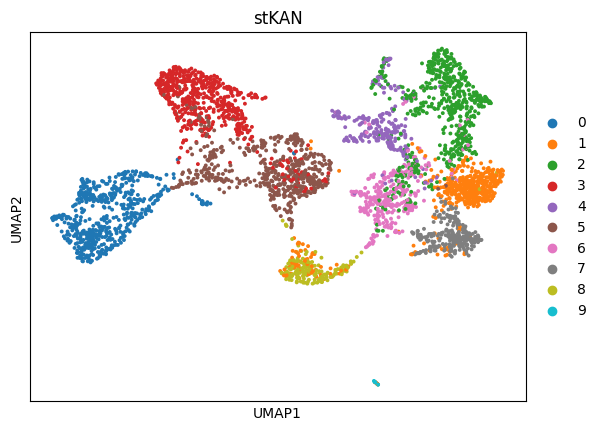

In [5]:
sc.pp.neighbors(combined_adata, use_rep='stKAN_embed')
sc.tl.umap(combined_adata)

sc.pl.umap(
    combined_adata,
    color="stKAN_refine_domain",
    title="stKAN"
)


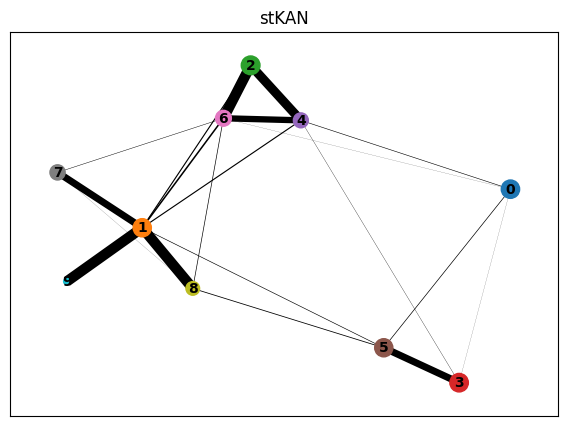

In [6]:
# 计算PAGA图
sc.tl.paga(combined_adata, groups="stKAN_refine_domain")
sc.pl.paga(combined_adata, color="stKAN_refine_domain", title="stKAN")

In [ ]:

fig, ax_list = plt.subplots(1, 3, figsize=(12, 3))

### Plotting UMAP before batch effect correction
sc.pp.normalize_total(combined_adata)
sc.pp.log1p(combined_adata)
sc.pp.pca(combined_adata)

sc.pp.neighbors(combined_adata, use_rep='X_pca', n_neighbors=10, n_pcs=40)
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color='data', title='Uncorrected',
                  ax = ax_list[0],
                  show=False)

### Plotting UMAP after batch effect correction
sc.pp.neighbors(combined_adata, use_rep='stKAN_embed', n_neighbors=10)
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata,
           color='data',
           ax=ax_list[1],
           title='Batch corrected',
           #legend_loc = 'bottom margin',
           show=False)

### Color by predicted domains
sc.pl.umap(combined_adata, color='stKAN_refine_domain', ax=ax_list[2], title='Colored by clusters', show=False)

plt.tight_layout(w_pad=0.02)


In [ ]:
from sklearn import metrics
### Splitting adata into Section 1 and Section 2
combined_adata_section1 = combined_adata[combined_adata.obs['data']=='S1', :]
combined_adata_section2 = combined_adata[combined_adata.obs['data']=='S3', :]
fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
sc.pl.embedding(combined_adata_section1,
                basis='spatial',
                color='stKAN_refine_domain',
                show = False,
                s=50,
                title='Section 1',
                ax = ax_list[0])

sc.pl.embedding(combined_adata_section2,
                basis='spatial',
                color='stKAN_refine_domain',
                show = False,
                s=50,
                title = ['Section 2'],
                ax = ax_list[1])

plt.tight_layout(w_pad=0.2)